In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.examples.tutorials.mnist import input_data

In [6]:

# mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

In [7]:
# def show_images(images, cols = 1, titles = None):
#     """Display a list of images in a single figure with matplotlib.
    
#     Parameters
#     ---------
#     images: List of np.arrays compatible with plt.imshow.
    
#     cols (Default = 1): Number of columns in figure (number of rows is 
#                         set to np.ceil(n_images/float(cols))).
    
#     titles: List of titles corresponding to each image. Must have
#             the same length as titles.
#     """
#     assert((titles is None)or (len(images) == len(titles)))
#     n_images = len(images)
#     if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
#     fig = plt.figure()
#     for n, (image, title) in enumerate(zip(images, titles)):
#         a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
#         plt.imshow(image)
#         a.set_title(title)
#     fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
#     plt.show()

# images = []
# for i in range(5):
#     images.append(second_layer_weights[:,:, 0, i]/255.0)
# show_images(images, cols=4)

In [66]:
class ConvNet:
    def __init__(self, data, validation_size=10000, learning_rate=1e-4, dropout=0.5, batch_size=50, num_epochs=20000):
        self.validation_size = validation_size
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.construct()
        self.validation_accuracy = []
        self.testing_accuracy = []
        self.losses = []
        self.i  = 0
        
        self.data = data
    
    def Stats(self):
        return self.losses, self.testing_accuracy, self.validation_accuracy
    
    def nextBatch(self):
        indices = self.data["train"]["images"].shape[0]
        batch_size = self.batch_size
        
        i = self.i
        if i + batch_size > indices:
            batch_size = indices - i
        
        
        
        batch_train = self.data["train"]["images"][i:i+self.batch_size, :]
        batch_labels = self.data["train"]["labels"][i:i+self.batch_size, :]
        
        i += batch_size
        if i >= indices:
            self.data["train"]["images"], self.data["train"]["labels"] = shuffle(self.data["train"]["images"], self.data["train"]["labels"])
    
        i %= indices
        
        
    
        self.i = i
        return batch_train, batch_labels 
        
    def construct(self):
        """
            Graph Setup
        """
        
        n_filters = 32
        stride_size = 10
        x = tf.placeholder(tf.float32, [None, 784])

        def constructConvolutionLayer(x, filter_shape, n_filters=32, channels=1, strides=[1, 1, 1, 1], padding='SAME'):
            w = tf.Variable(tf.truncated_normal([filter_shape[0], filter_shape[1], channels, n_filters], stddev= 0.05), name="w")
            b = tf.Variable(tf.zeros([n_filters]), name="b")

            conv = tf.nn.conv2d(x, w, strides=strides, padding=padding)
            return conv + b, w, b

        # conv1
        with tf.variable_scope("conv1"):
            reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
            conv, w, _ = constructConvolutionLayer(reshaped, [5, 5], 32, 1)
        conv1 = tf.nn.relu(conv)

        # pooling 1
        pooling1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # conv2
        old_n_filters = n_filters
        n_filters = 128
        with tf.variable_scope("conv2"):
            conv, w, _ = constructConvolutionLayer(pooling1, [5, 5], n_filters, old_n_filters)
        conv2 = tf.nn.relu(conv)

        # pooling
        pooling2 =  tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # conv3 
        old_n_filters = n_filters
        n_filters = 128
        with tf.variable_scope("conv3"):
            conv, w, _ = constructConvolutionLayer(pooling2, [5, 5], n_filters, old_n_filters)
        conv3 = tf.nn.relu(conv)

#         # pooling
        pooling3 =  tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
#         # conv4
        old_n_filters = n_filters
        n_filters = 128
        with tf.variable_scope("conv4"):
            conv, w, _ = constructConvolutionLayer(pooling3, [5, 5], n_filters, old_n_filters)
        conv4 = tf.nn.relu(conv)
        # pooling
        pooling4 =  tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
#         # conv4
#         old_n_filters = n_filters
#         n_filters = 384
#         with tf.variable_scope("conv5"):
#             conv, w, _ = constructConvolutionLayer(pooling4, [5, 5], n_filters, old_n_filters)
#         conv5 = tf.nn.relu(conv)
#         # pooling
#         pooling5 =  tf.nn.max_pool(conv5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
#         # conv4
#         old_n_filters = n_filters
#         n_filters = 456
#         with tf.variable_scope("conv6"):
#             conv, w, _ = constructConvolutionLayer(pooling5, [5, 5], n_filters, old_n_filters)
#         conv6 = tf.nn.relu(conv)
#         # pooling
#         pooling6 =  tf.nn.max_pool(conv6, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        
        
        # add fully connected layer
        fc_i = tf.contrib.layers.flatten(pooling4)
        w = tf.Variable(tf.truncated_normal([fc_i.get_shape().as_list()[1], 1024], stddev=0.03))
        b = tf.Variable(tf.zeros([1024]))

        fc_f = tf.nn.relu(tf.matmul(fc_i, w) + b)

        # dropout
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(fc_f, keep_prob)
        
        # add output layer
        w = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.03))
        b = tf.Variable(tf.zeros([10]))
        
        outputs = tf.matmul(h_fc1_drop, w) + b
#         outputs = tf.nn.dropout(outputs, keep_prob)
        
        self.predictions = tf.argmax(tf.nn.softmax(outputs), 1)

        labels = tf.placeholder(tf.float32, [None, 10])
        # regularization = tf.nn.
        loss = tf.losses.softmax_cross_entropy(labels, outputs)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outputs, labels=labels))
        train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(cross_entropy)
        
        correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.train_step = train_step
        self.loss = loss
        self.accuracy = accuracy
        self.x = x
        self.labels = labels
        self.keep_prob = keep_prob
        
    def printParameters(self):
        print("learning rate: {}, batch size: {}, dropout prob: {}, # epochs: {}".format(self.learning_rate, self.batch_size, self.dropout, self.num_epochs))
        
        
    def train(self):
        """
                Training
        """
        print("Starting training.....")
        self.printParameters()
        print()
        
        with tf.Session() as session:
            tf.global_variables_initializer().run(session=session)
            tf.local_variables_initializer().run(session=session)
            
            average_loss = 0
            start = time.time()
            losses = []
            testing_accuracy = []
            validation_accuracy = []
            l = 0
            
            for i in range(self.num_epochs):
                batch_images, batch_labels = self.nextBatch()
                _, l = session.run([self.train_step, self.loss], feed_dict={self.x: batch_images, self.labels:batch_labels, self.keep_prob: 0.5})

                average_loss += l

                if i > 0 and i % 1000 == 0:
                    average_loss /= 1000
                    validation_loss = session.run(self.accuracy, feed_dict={self.x: self.data["validation"]["images"], self.labels: self.data["validation"]["labels"], self.keep_prob: self.dropout})
                    
                    self.losses.append(average_loss)
                    self.validation_accuracy.append(validation_loss)
                    
                    if average_loss < min(self.losses):
                        print("step: {}, loss: {}*, validation accuracy: {:0.2f}%"
                                          .format(i, average_loss, validation_loss * 100) )
                    else:
                        print("step: {}, loss: {}, validation accuracy: {:0.2f}%"
                                          .format(i, average_loss, validation_loss * 100) )
                    
                    average_loss = 0
                
                
                losses.append(l)
                
            end = time.time() - start
            
            
            
            results = session.run([self.predictions], feed_dict={self.x: self.data["test"]["images"], self.keep_prob: 1.0})
            validation_loss = session.run(self.accuracy, feed_dict={self.x: self.data["validation"]["images"], self.labels: self.data["validation"]["labels"], self.keep_prob: self.dropout})
            
            print("final validation accuracy: {}".format(validation_loss))
            print("Training completed in {:.0f}m{:.0f}s".format(end // 60, end % 60))
            print()
            
        return results, validation_loss, losses
        
#     def getTestEvaluation(self):
#             with tf.Session() as session:
#                 tf.global_variables_initializer().run(session=session)
#                 tf.local_variables_initializer().run(session=session)

#                 results = session.run([self.predictions], feed_dict={self.x: self.data["test"]["images"], self.keep_prob: 1.0})
            
#             return results
                
                

In [67]:
import zipfile
import pandas as pd
import numpy as np

"""
    Shuffling two arrays in unison
    https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
"""
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def mnistZip(filepath):
    with zipfile.ZipFile(filepath, 'r') as data_zip:
        train = data_zip.open('train.csv')
        test = data_zip.open('test.csv')

        train = pd.read_csv(train, skiprows=0).values
        test = pd.read_csv(test, skiprows=0).values
    
    return train, test

def formatData(data):
    labels = np.zeros(shape=( data.shape[0], 10))
    
    i = 0
    for row in data:
        labels[i, row[0]] = 1.0
        i += 1
    images = data[:, 1:] 
    
    return images, labels

def loadData():
    kaggle_zip = './kaggle mnist/data.zip'

    train, test = mnistZip(kaggle_zip)
    train_data, train_labels = formatData(train)
    

    n_data_points = train_data.shape[0]
    
    validation_size = 2000
    data = {}
    data["train"] = {}
    data["train"]["images"] = train_data[:n_data_points - validation_size, :] / 255.0
    data["train"]["labels"] = train_labels[:n_data_points - validation_size, :]

    flipped = np.fliplr(data["train"]["images"])
    idx = np.random.randint(flipped.shape[0], size=10000)
    flipped = flipped[idx, :]
    
    # add rotated
    
    data["train"]["images"] = np.concatenate((data["train"]["images"], flipped))
    data["train"]["labels"] = np.concatenate((data["train"]["labels"], data["train"]["labels"][idx, :]))
    
    data["train"]["images"], data["train"]["labels"] = shuffle(data["train"]["images"], data["train"]["labels"])
    
    data["validation"] = {}
    data["validation"]["images"] = train_data[n_data_points - validation_size:, :] / 255.0
    data["validation"]["labels"] = train_labels[n_data_points - validation_size:, :]
    

    data["test"] = {}
    data["test"]["images"] = test / 255.0
#     data["test"]["labels"] = test_labels
    
    return data


In [62]:
data = loadData()


In [68]:
c = ConvNet(data=data, num_epochs=30000, batch_size=50, learning_rate=4e-4)
training_results = c.train()

Starting training.....
learning rate: 0.0004, batch size: 50, dropout prob: 0.5, # epochs: 30000

step: 1000, loss: 0.2835795019371435, validation accuracy: 97.50%
step: 2000, loss: 0.07607831791229545, validation accuracy: 98.50%
step: 3000, loss: 0.04856750481936615, validation accuracy: 97.90%
step: 4000, loss: 0.038329718826342285, validation accuracy: 98.30%
step: 5000, loss: 0.028408679154948914, validation accuracy: 98.45%
step: 6000, loss: 0.024872349584504263, validation accuracy: 98.65%
step: 7000, loss: 0.02071105312540749, validation accuracy: 98.70%
step: 8000, loss: 0.01606509910063596, validation accuracy: 98.60%
step: 9000, loss: 0.01458736346693513, validation accuracy: 99.05%
step: 10000, loss: 0.013936494874949404, validation accuracy: 98.20%
step: 11000, loss: 0.012654520855456439, validation accuracy: 98.35%
step: 12000, loss: 0.009391794633145366, validation accuracy: 98.75%
step: 13000, loss: 0.009952345990651451, validation accuracy: 98.95%
step: 14000, loss: 0.

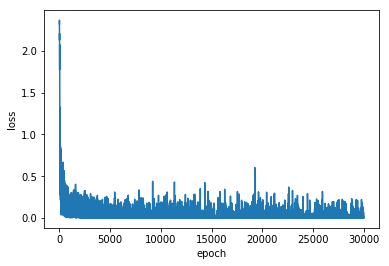

In [69]:
res, v_a, losses = training_results
saveResult(res[0], "final2------------.csv")
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
"""
    Testing
"""
learning_rates = [1e-4]
# batch_sizes = [x for x in range(32, 128, (128-32)//2)]
batch_sizes = [100]
num_epochs = [20000]
dropout = [0.5]

results = []
for lr in sorted(learning_rates):
    for batch_size in sorted(batch_sizes):
        for epochs in sorted(num_epochs):
            for dr in sorted(dropout):
                cnn = ConvNet(data=data, learning_rate=lr, batch_size=batch_size, num_epochs=epochs, dropout=dr)
                result, v_a, losses = cnn.train()
                
                results.append({"dropout": dropout, "num_epochs": epochs, "batch_size": batch_size, 
                                "learning_rate": lr,"final validation_accuracy": v_a, "results": result,
                               "losses": losses})

In [56]:
import os
def plotResults(results):
    for result in results:
        plt.plot(result["losses"], label="learning rate: {}".format(result["learning_rate"]))
    plt.legend(loc='best', frameon=False)
    plt.show()
    
def saveResult(result, filename):
    indices = [i+1 for i in range(len(result))]
    kaggle_submission = pd.DataFrame(data={"ImageId": indices, "Label": result})
    
    if os.path.exists(filename):
        os.remove(filename)
    with open(filename, "w") as f:
        kaggle_submission.to_csv(f, index=False)

for i, result in enumerate(results):
    saveResult(result["results"][0], "/output/{}-deep-convnet-2.csv".format(i))
# print(results)

NameError: name 'results' is not defined

In [ ]:


kaggle_submission.head()

In [ ]:
index = 4
plt.imshow(np.reshape(data["test"]["images"][index, :], (28, 28)))
plt.show()
print((results[0][index]))